# Fashion MNIST

Author: Jingqi Yao

Course Project, UC Irvine, Math 10, S22

## Introduction

Introduce your project here.  Maybe 3 sentences.

The goal of the project is to classify 28*28 grayscale images about 10 different types of clothing into their own categories. The project focuses on improving the classification score for the test datatset using logistic regression and convolutional neural network.

## Main portion of the project

### Import Data
Since the dataset I used for this project is larger than 100 MB, I integrated the dataset to Deepnote by using "Shared dataset" function. I connect this project to the uploaded datasets, so I am able to use them by accessing /datasets/fashion-mnist directory.

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv("/datasets/fashion-mnist/fashion-mnist_train.csv")
X_train = train.loc[:, train.columns != "label"]
y_train = train["label"]
test = pd.read_csv("/datasets/fashion-mnist/fashion-mnist_test.csv")
X_test = test.loc[:, test.columns != "label"]
y_test = test["label"]

In [ ]:
labels = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(solver="sag")
clf.fit(X_train, y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='sag')

In [ ]:
lr_test_acc = clf.score(X_test, y_test)
print(f"The mean accuracy for the train data is {clf.score(X_train, y_train)}")
print(f"The mean accuracy for the test data is {clf.score(X_test, y_test)}")
print(f"Overfitting is not a concern, because the difference is {100*(clf.score(X_train, y_train) - clf.score(X_test, y_test)):.2f}%, which is less than 5%.")

The mean accuracy for the train data is 0.8772833333333333
The mean accuracy for the test data is 0.8488
Overfitting is not a concern, because the difference is 2.85%, which is less than 5%.


In [ ]:
# df stores actural label and predicted label for each row
df = pd.DataFrame({"Label": y_test, "Pred": pd.Series(clf.predict(X_test))})
df.head()

,Label,Pred
0,0,0
1,1,1
2,2,2
3,2,2
4,3,4


In [ ]:
import altair as alt
alt.data_transformers.enable('default', max_rows=10000)

c = alt.Chart(df).mark_rect().encode(
    x="Label:N",
    y="Pred:N",
    color=alt.Color('count()', scale=alt.Scale(scheme='turbo'))
)

c_text = alt.Chart(df).mark_text(color="white").encode(
    x="Label:N",
    y="Pred:N",
    text="count()"
)

(c+c_text).properties(
    height=400,
    width=400
)

alt.LayerChart(...)

In [ ]:
print(f"{'Label': <20}{'% of wrong pred'}")
print()
for label, sub_df in df.groupby("Label"):
    print(f"{label} {labels[label]: <20}{100*(sub_df[sub_df['Pred'] != label].shape[0]/sub_df.shape[0]):.1f}")
    # print(sub_df[sub_df["Pred"] != label])

Label               % of wrong pred

0 T_shirt/top         19.4
1 Trouser             2.5
2 Pullover            24.1
3 Dress               14.1
4 Coat                19.8
5 Sandal              10.9
6 Shirt               40.9
7 Sneaker             8.2
8 Bag                 6.2
9 Ankle boot          5.1


The most wrongly predicated label is Shirt. 

### CNN

The logistic regression does not have very accurate prediction on confounding classes like T-shirt and shirt. Next, I am going to use CNN to increase the predication accuracy.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, Reshape, AveragePooling2D
from keras.optimizers import Adam
import numpy as np
from keras.utils import to_categorical

In [ ]:
X_train = np.asarray(X_train)
X_train = X_train.reshape(60000, 28, 28)

X_test = np.asarray(X_test)
X_test = X_test.reshape(10000, 28, 28)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Two convolutional layers are used in this CNN network and max pooling technique is used for its ability to extract the most crucial spatial information of the 2D dimension. The first layer has filter channels of 6 with the size of 3 x 3. The output layer has the shape of (6, 14, 14) after the max pooling layer. The second layer has filter channels of 16 with the size of 3x3. The output layer has the hape of (16, 7, 7) after the max pooling layer. The output is then flattened using the dense layer which contains 784 parameters. Finally, the dense layer is outputted into 10 classes for prediction. 

![Picture title](image-20220612-184139.png)

In [ ]:
cnn = Sequential()

cnn.add(Conv2D(filters = 6, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Dropout(0.15))

cnn.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'))
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Dropout(0.2))

cnn.add(Flatten())
cnn.add(Dense(784, activation='relu'))
cnn.add(Dense(10, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
cnn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size = 32, shuffle = True)

Epoch 1/15
1875/1875 [==============================] - 55s 29ms/step - loss: 1.3745 - accuracy: 0.7635 - val_loss: 0.4148 - val_accuracy: 0.8503
Epoch 2/15
1875/1875 [==============================] - 54s 29ms/step - loss: 0.4332 - accuracy: 0.8410 - val_loss: 0.3294 - val_accuracy: 0.8747
Epoch 3/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3730 - accuracy: 0.8618 - val_loss: 0.3133 - val_accuracy: 0.8827
Epoch 4/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3436 - accuracy: 0.8720 - val_loss: 0.2953 - val_accuracy: 0.8880
Epoch 5/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3198 - accuracy: 0.8808 - val_loss: 0.2846 - val_accuracy: 0.8959
Epoch 6/15
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2996 - accuracy: 0.8887 - val_loss: 0.2625 - val_accuracy: 0.9031
Epoch 7/15
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2841 - accuracy: 0.8936 - val_loss: 0.2681 -

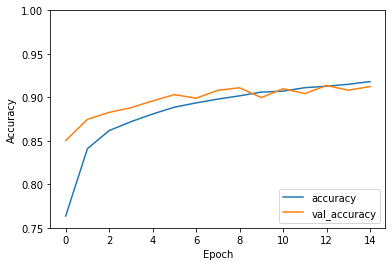

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

In [ ]:
cnn_test_loss, cnn_test_acc = cnn.evaluate(X_test, y_test, verbose=2)
print(f"The test accuracy is {cnn_test_acc}, which is {(cnn_test_acc - lr_test_acc)*100}% higher than the logistoc regression model.")

313/313 - 3s - loss: 0.2509 - accuracy: 0.9124 - 3s/epoch - 10ms/step
The test accuracy is 0.9124000072479248, which is 6.360000724792481% higher than the logistoc regression model.


In [ ]:
df_cnn = pd.DataFrame({"Pred": np.argmax(cnn.predict(X_test), axis=1).tolist(), "Label": np.argmax(y_test, axis=1).tolist()})
df_cnn.head()

313/313 [==============================] - 3s 11ms/step


,Pred,Label
0,0,0
1,1,1
2,2,2
3,2,2
4,3,3


In [ ]:
c_cnn = alt.Chart(df_cnn).mark_rect().encode(
    x="Label:N",
    y="Pred:N",
    color=alt.Color('count()', scale=alt.Scale(scheme='turbo'))
)

c_text_cnn = alt.Chart(df_cnn).mark_text(color="white").encode(
    x="Label:N",
    y="Pred:N",
    text="count()"
)

(c_cnn+c_text_cnn).properties(
    height=400,
    width=400
)

alt.LayerChart(...)

We can see an improvement of number of correctly predicted images on the chart. However, T-shirts and shirts are still the most confounding items due to their nature of similarity.

## Summary

Either summarize what you did, or summarize the results.  Maybe 3 sentences.

On the Fashion MNIST dataset, CNN model with appropriate parameters outperform the logistic regression, by around 6%. The logistic regression can serve as a baseline in this type of image classification, while to improve the accuracy in general, we can use CNN model and fine tune the parameters to achieve better score.

## References

* What is the source of your dataset(s)?

https://www.kaggle.com/datasets/zalando-research/fashionmnist

* Were any portions of the code or ideas taken from another source?  List those sources here and say how they were used.

https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial/notebook I learnt the structure of CNN from here

https://www.tensorflow.org/tutorials/images/cnn I use the method of evaluating CNN model mentioned here


* List other references that you found helpful.

https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529

https://keras.io/api/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=63211abb-10b5-43c5-9dac-7f5ad739c20f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>